# Hematopoiesis - Initial state identification

Construct diffusion pseudotime on NeurIPS 2021 hematopoiesis data.

In [1]:
import sys

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "pseudotime_kernel" / "hematopoiesis").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "hematopoiesis" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
CELLTYPES_TO_KEEP = [
    "HSC",
    "MK/E prog",
    "Proerythroblast",
    "Erythroblast",
    "Normoblast",
    "cDC2",
    "pDC",
    "G/M prog",
    "CD14+ Mono",
]

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "hematopoiesis" / "processed" / "gex_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 67568 × 25629
    obs: 'site', 'donor', 'batch', 'l1_cell_type', 'l2_cell_type'
    var: 'hvg_multiVI'
    uns: 'neighbors', 'umap'
    obsm: 'MultiVI_latent', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

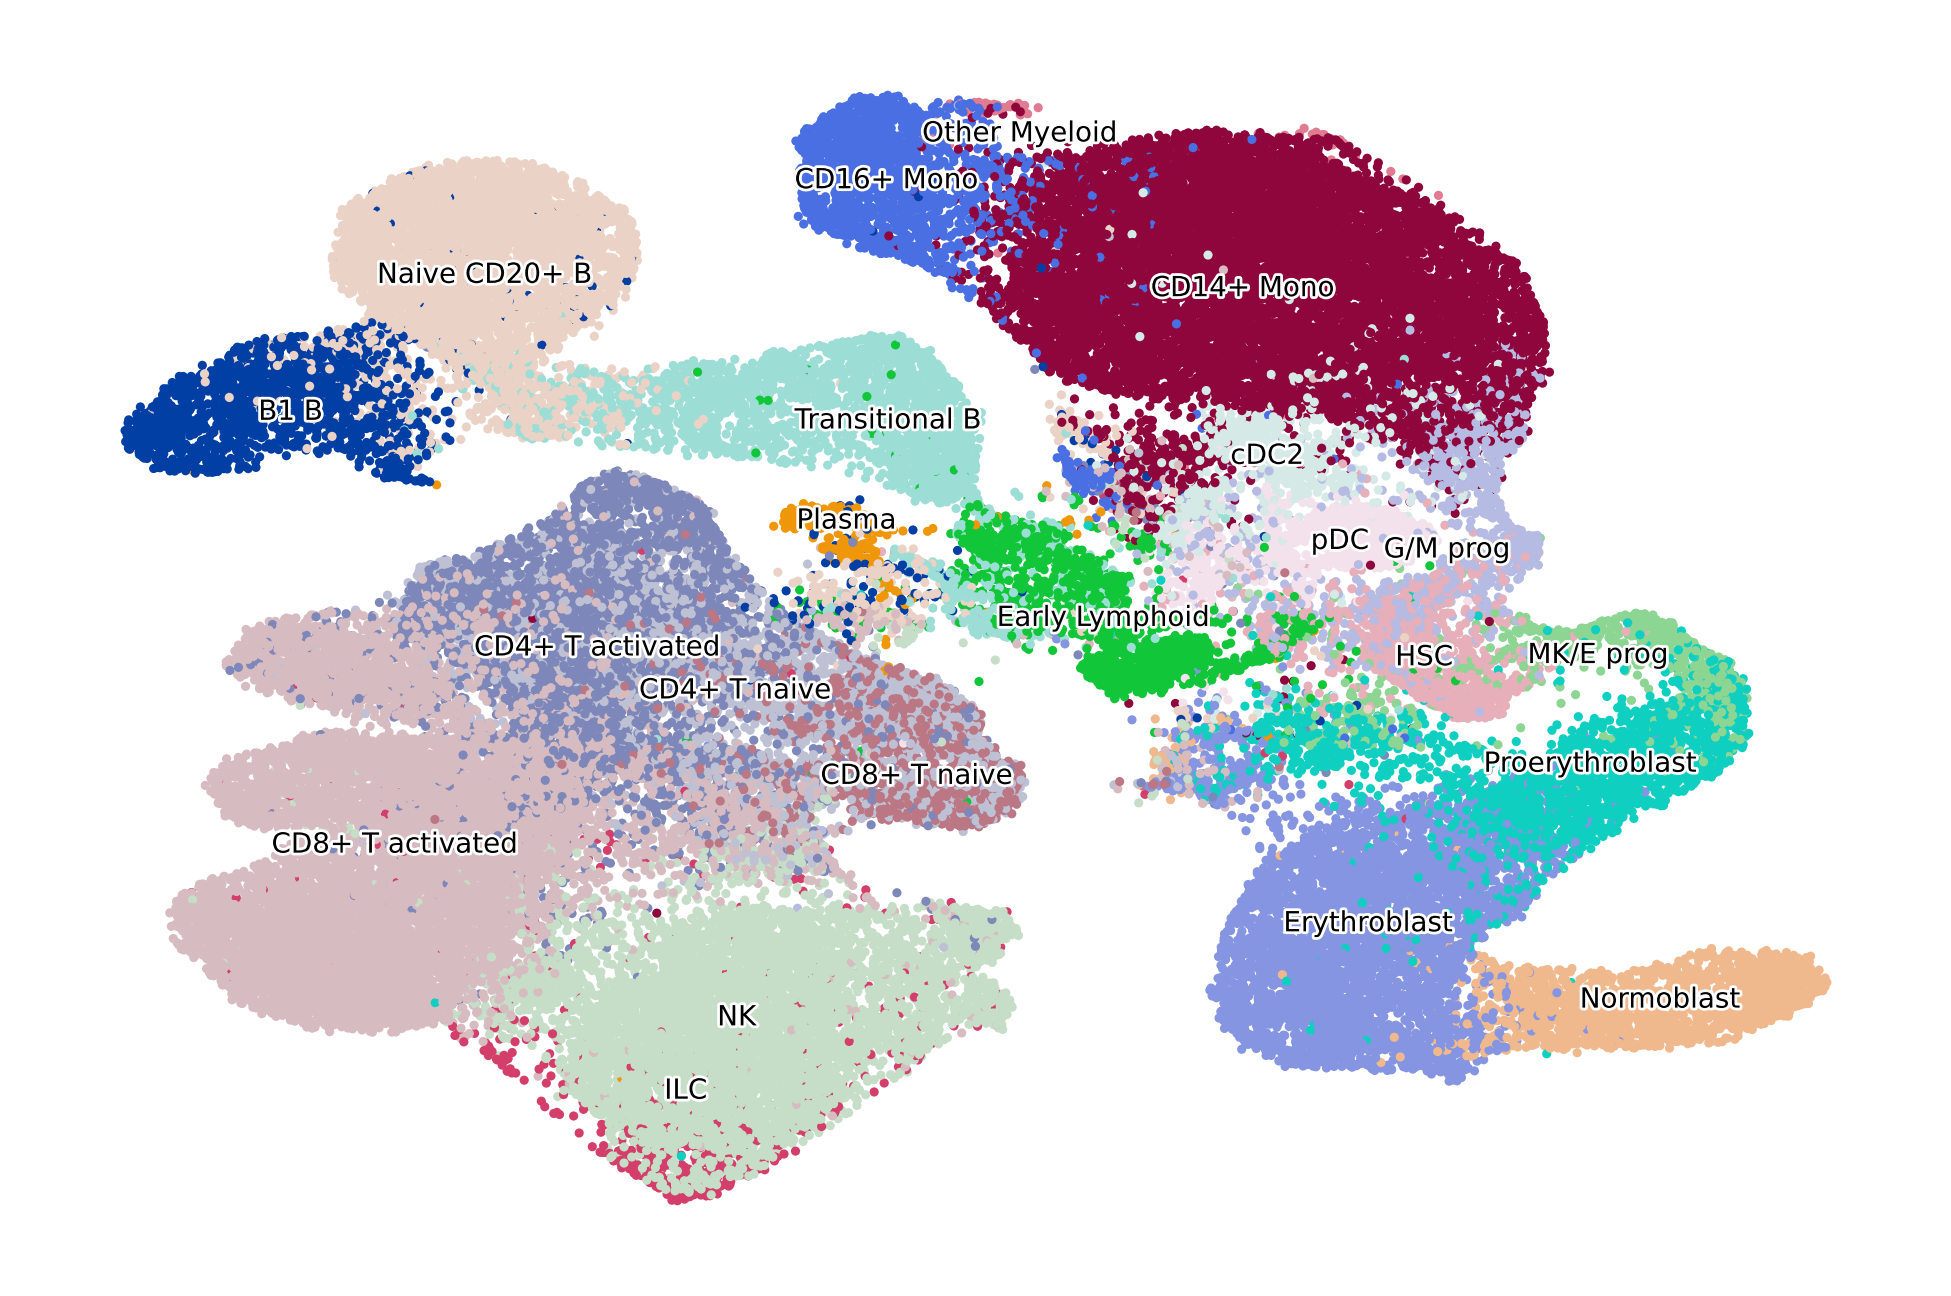

In [8]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="X_umap", c="l2_cell_type", dpi=200, title="", legend_fontsize=5, legend_fontweight=1)

## Data preprocessing

In [9]:
adata = adata[adata.obs["l2_cell_type"].isin(CELLTYPES_TO_KEEP), :].copy()
adata

AnnData object with n_obs × n_vars = 24440 × 25629
    obs: 'site', 'donor', 'batch', 'l1_cell_type', 'l2_cell_type'
    var: 'hvg_multiVI'
    uns: 'neighbors', 'umap', 'l2_cell_type_colors'
    obsm: 'MultiVI_latent', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
sc.pp.neighbors(adata, use_rep="MultiVI_latent")
sc.tl.umap(adata)

computing neighbors
    finished (0:02:34)
computing UMAP
    finished (0:00:12)


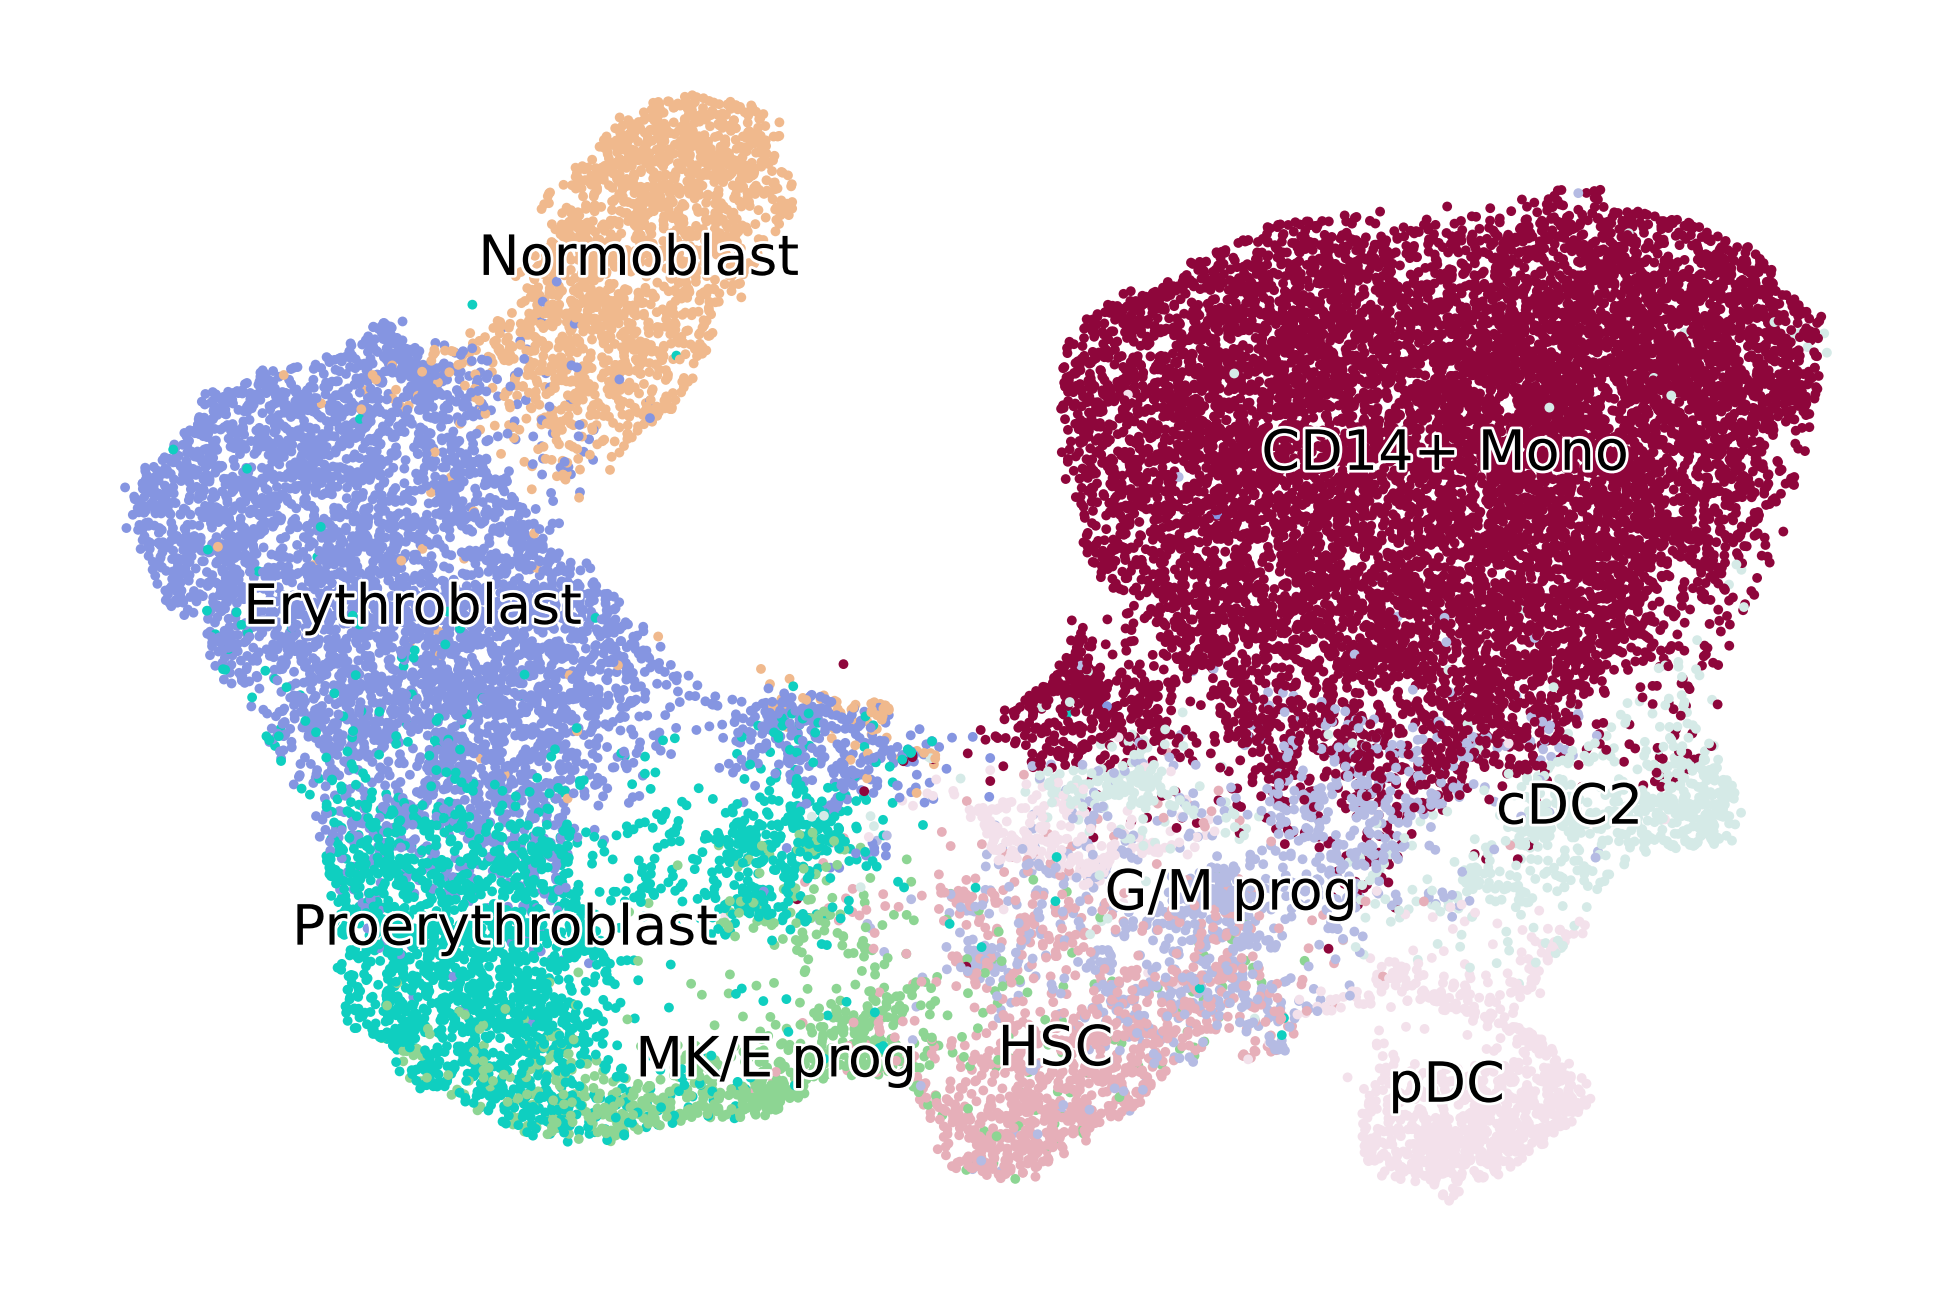

In [11]:
if running_in_notebook():
    scv.pl.scatter(
        adata,
        basis="X_umap",
        c="l2_cell_type",
        dpi=200,
        title="",
        legend_fontsize=10,
        legend_fontweight=5,
    )

## Diffusion pseudotime

In [12]:
sc.tl.diffmap(adata, n_comps=15)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99922997 0.9977195  0.9968419  0.9955766  0.9942717
     0.9900949  0.9884704  0.9867782  0.9852537  0.9849594  0.9830871
     0.98229724 0.9809607  0.97756666]
    finished (0:00:02)


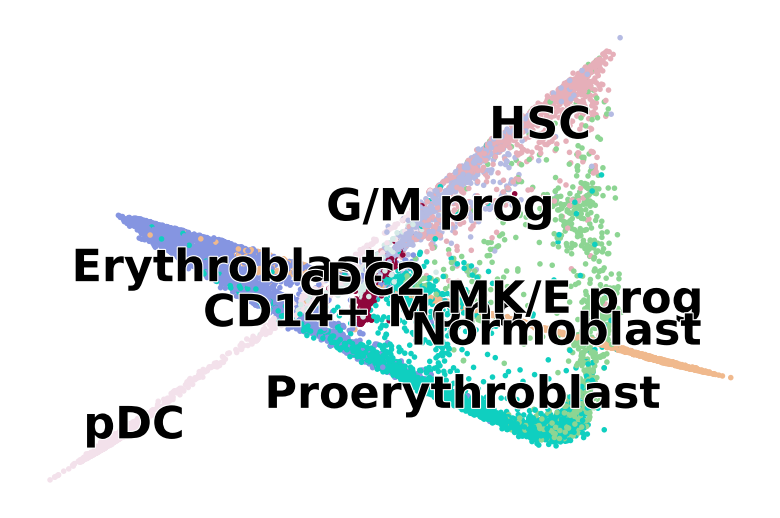

In [13]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata, basis="diffmap", color=["l2_cell_type"], components=["4, 5"], size=25, dpi=100, title="", ax=ax
    )

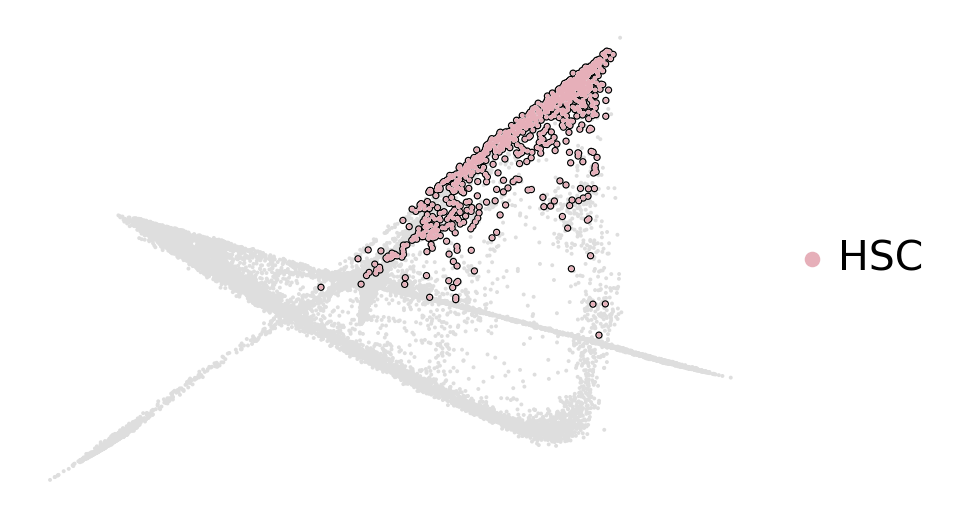

In [14]:
adata.obs["hsc_cluster"] = (
    adata.obs["l2_cell_type"]
    .astype("str")
    .replace(
        {
            "MK/E prog": "nan",
            "Proerythroblast": "nan",
            "Erythroblast": "nan",
            "Normoblast": "nan",
            "cDC2": "nan",
            "pDC": "nan",
            "G/M prog": "nan",
            "CD14+ Mono": "nan",
        }
    )
    .astype("category")
    .cat.reorder_categories(["nan", "HSC"])
    .copy()
)

celltype_colors = dict(zip(adata.obs["l2_cell_type"].cat.categories, adata.uns["l2_cell_type_colors"]))
adata.uns["hsc_cluster_colors"] = ["#dedede", celltype_colors["HSC"]]

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=["hsc_cluster"],
        legend_loc="right",
        components=["4, 5"],
        add_outline="HSC",
        title="",
        ax=ax,
    )

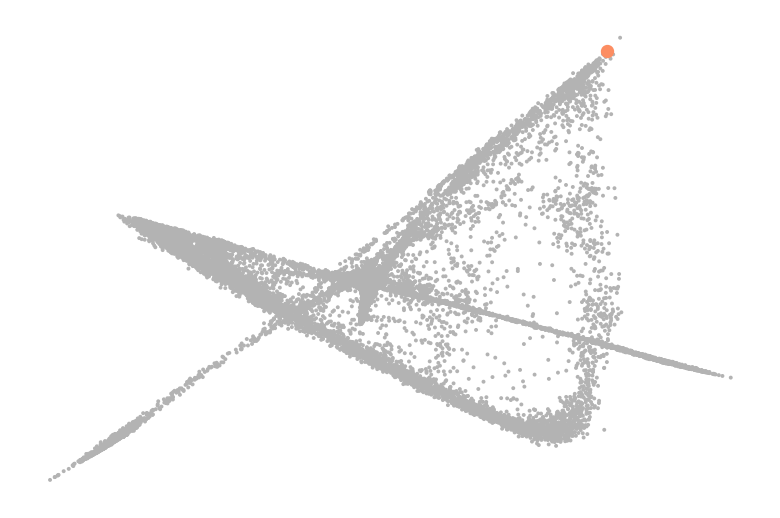

In [15]:
df = (
    pd.DataFrame(
        {
            "diff_comp": adata.obsm["X_diffmap"][:, 5],
            "cell_type": adata.obs["l2_cell_type"].values,
        }
    )
    .reset_index()
    .rename({"index": "obs_id"}, axis=1)
)
df = df.loc[df["cell_type"] == "HSC", "diff_comp"]
root_idx = df.index[df.argmax()]

set2_cmap = sns.color_palette("Set2").as_hex()
palette = [set2_cmap[-1], set2_cmap[1]]

if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="diffmap", c=root_idx, legend_loc=False, palette=palette, components=["4, 5"], ax=ax)

In [16]:
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata, n_dcs=6)

computing Diffusion Pseudotime using n_dcs=6
    finished (0:00:00)


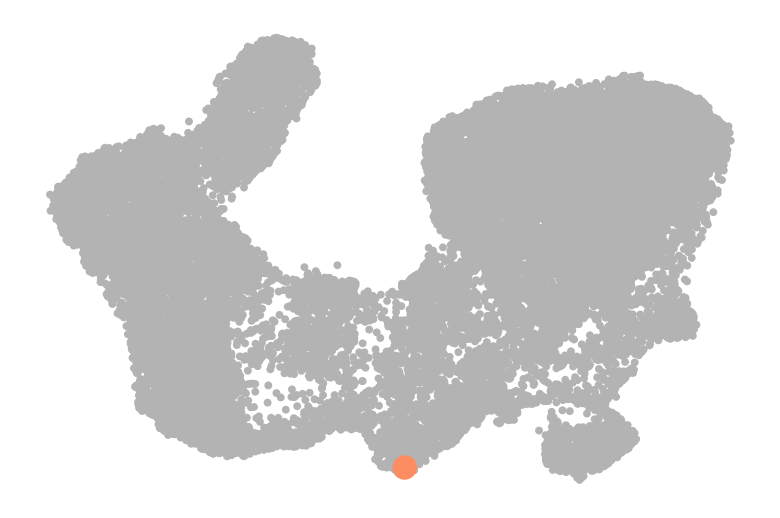

In [17]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color=root_idx, palette=palette, color_map="viridis", size=50, ax=ax)

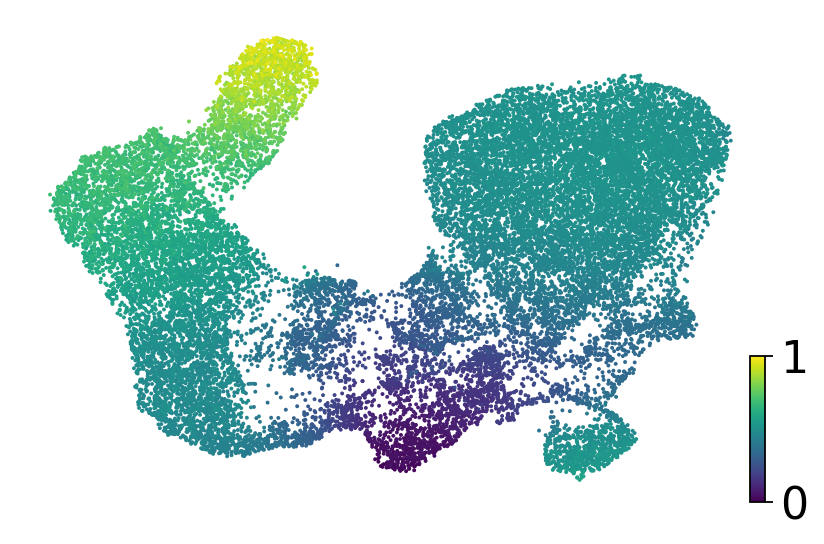

In [18]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="dpt_pseudotime", title="", color_map="viridis", ax=ax)

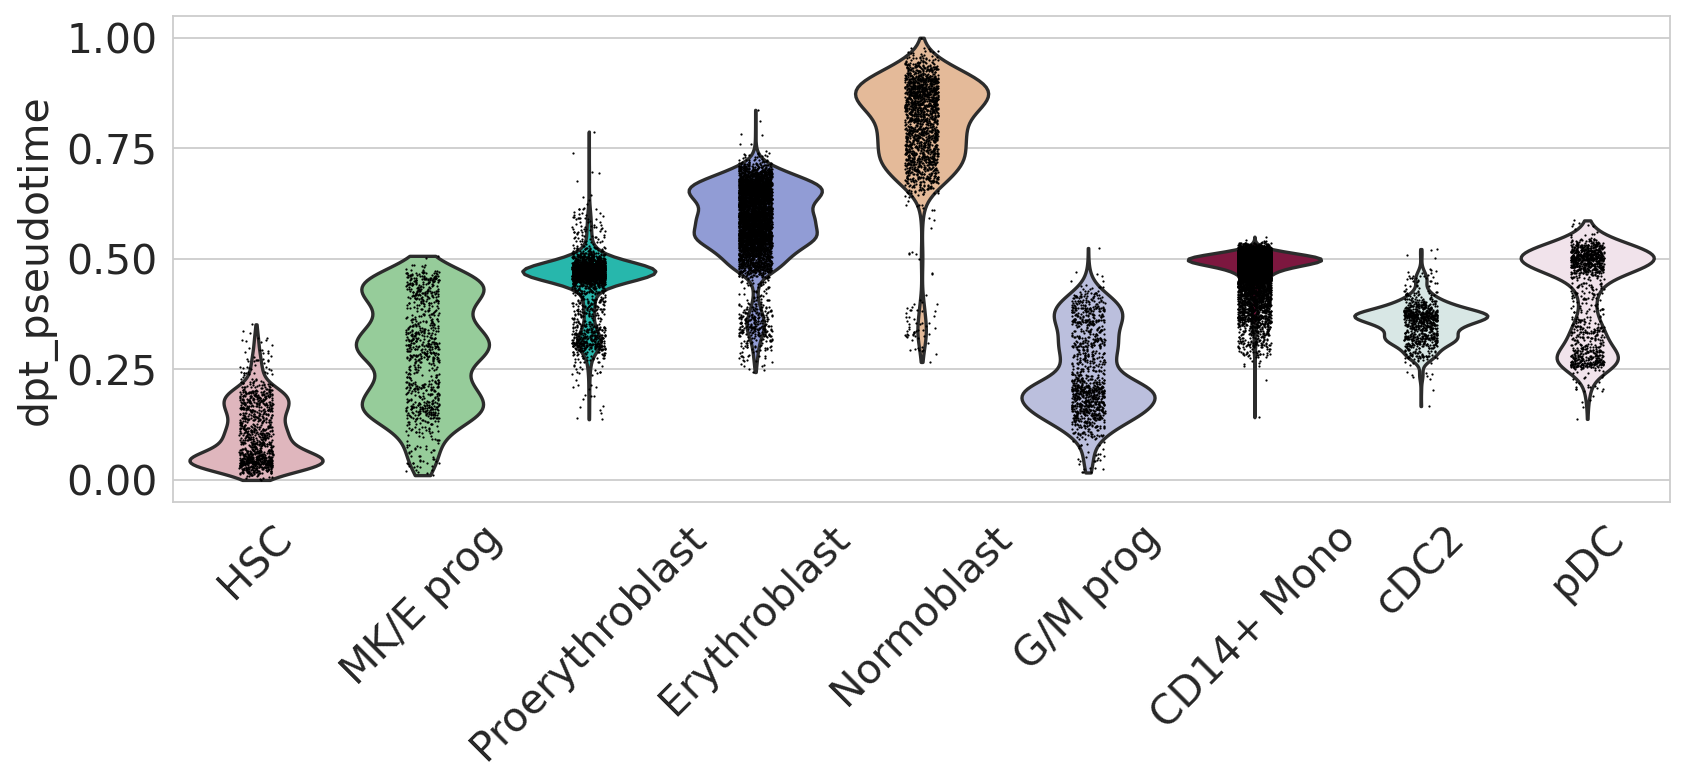

In [19]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["dpt_pseudotime"],
        groupby="l2_cell_type",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "HSC",
            "MK/E prog",
            "Proerythroblast",
            "Erythroblast",
            "Normoblast",
            "G/M prog",
            "CD14+ Mono",
            "cDC2",
            "pDC",
        ],
        ax=ax,
    )

    sns.reset_orig()

## CellRank

### Kernel

In [20]:
ptk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime").compute_transition_matrix(threshold_scheme="soft")
ptk.transition_matrix = ptk.transition_matrix.T

Computing transition matrix based on pseudotime


  0%|          | 0/24440 [00:00<?, ?cell/s]

    Finish (0:00:14)


### Estimator

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


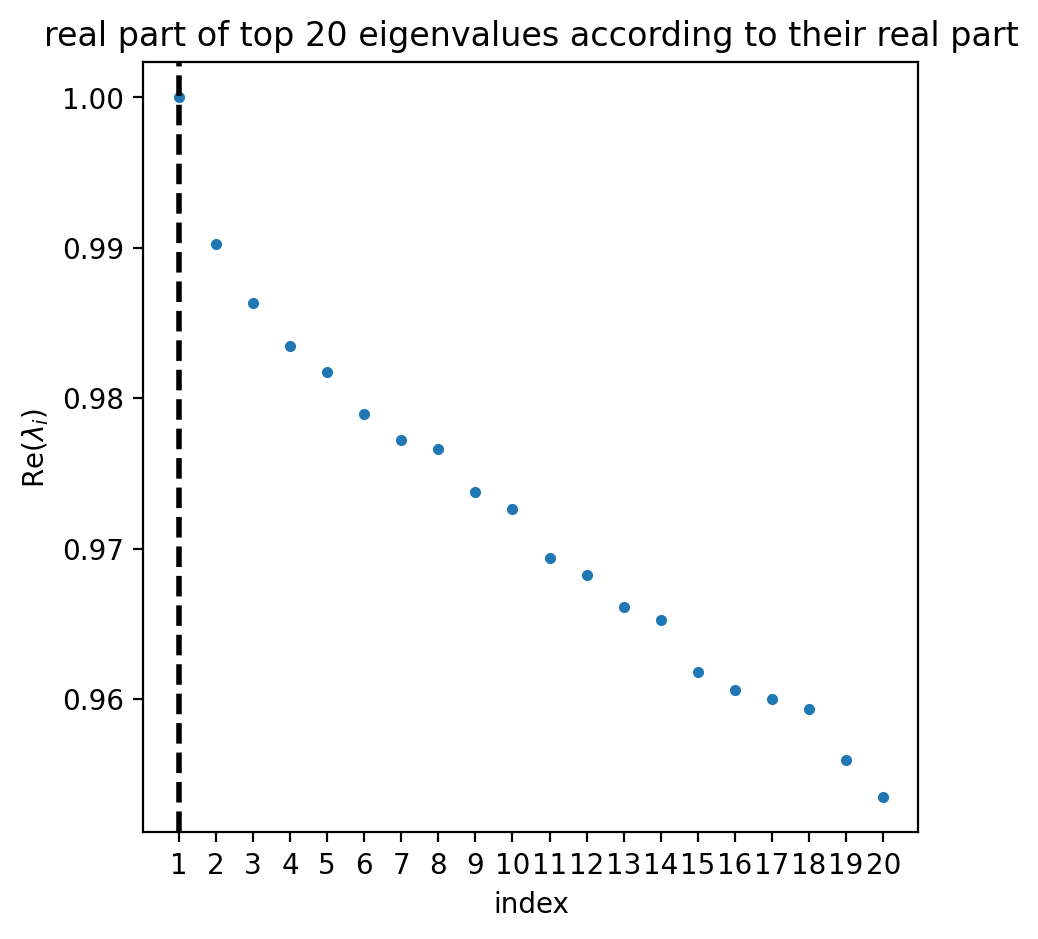

In [21]:
estimator = cr.estimators.GPCCA(ptk)
estimator.compute_schur(n_components=20)
estimator.plot_spectrum(real_only=True)
plt.show()

For 1 macrostate, stationary distribution is computed
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:06)
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)


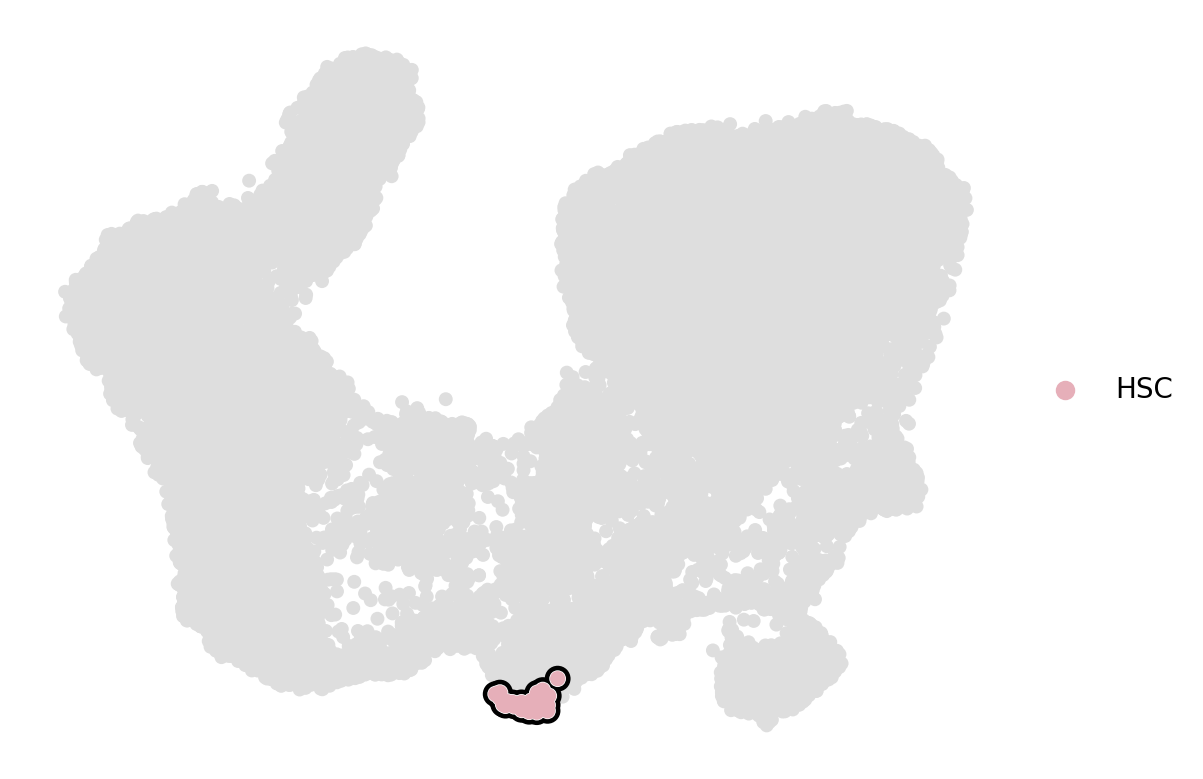

In [22]:
estimator.compute_macrostates(1, cluster_key="l2_cell_type")
if running_in_notebook():
    estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc="right", size=100)
    if SAVE_FIGURES:
        fpath = (
            FIG_DIR
            / "pseudotime_kernel"
            / "hematopoiesis"
            / f"umap_colored_by_cr_dpt_macrostates-initial_state.{FIGURE_FORMAT}"
        )
        estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)